In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tnrange

In [2]:
class KArmedBanditEnv:
    def __init__(self, n_arms, q_start_init=1., q_stdev=1.):
        self.n_arms = n_arms
        self.q_start_init = q_start_init
        self.q_stdev = q_stdev
        self.reset()
    
    def reset(self, from_q_init=True):
        if from_q_init:
            self.q_stars = np.ones(self.n_arms)*self.q_start_init
        else:
            self.q_stars = np.random.normal(loc=0., scale=1., size=(self.n_arms,))
        
    def draw_reward(self, a):
        qa_mu = self.q_stars[a]
        return np.random.normal(qa_mu, self.q_stdev)
    
    def get_optimal_a(self):
        return np.argmax(self.q_stars)

    def apply_random_walk(self, mu=0, stdev=0.01):
        self.q_stars += np.random.normal(mu, stdev, self.q_stars.shape)

        
class EpsilonGreedyPolicy:
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.reset()
        
    def reset(self):
        self.Qs = np.zeros(self.n_arms)
    
    def sample_action(self):
        rand = np.random.rand()
        if rand >= self.epsilon: # exploit sample-average estimate
            a = np.argmax(self.Qs)
        else: # sample greedy action
            a = np.random.randint(0, self.n_arms)
        return a
    
    def update_reward(self, a, r):
        raise NotImplementedError()


class SampleAveragePolicy(EpsilonGreedyPolicy):
    def __init__(self, n_arms, epsilon=0.1):
        super().__init__(n_arms, epsilon)
        
    def reset(self):
        super().reset()
        self.Ns = np.zeros(self.n_arms)
    
    def update_reward(self, a, r):
        self.Ns[a] += 1
        self.Qs[a] = self.Qs[a] + 1./(self.Ns[a])*(r-self.Qs[a])

        
class FixedAlphaPolicy(EpsilonGreedyPolicy):
    def __init__(self, n_arms, epsilon=0.1, alpha=0.1):
        super().__init__(n_arms, epsilon)
        self.alpha =alpha
        
    def update_reward(self, a, r):
        self.Qs[a] = self.Qs[a] + self.alpha*(r-self.Qs[a])

        
class Stats:
    def __init__(self, n_runs, n_steps):
        self.n_runs = n_runs
        self.n_steps = n_steps
        self.reset()
        
    def reset(self):
        self.rewards = np.zeros((self.n_runs, self.n_steps))
        self.optimal_action = np.zeros((self.n_runs, self.n_steps))
        
    def update(self, run, step, r, a_chosen, a_opt):
        self.rewards[run, step] = r
        self.optimal_action[run, step] = (a_chosen == a_opt)
        
    def get_avg_rewards(self):
        return np.mean(self.rewards, axis=0)

    def get_avg_optimacy(self):
        return np.mean(self.optimal_action, axis=0)

In [3]:
N_ARMS = 10
N_RUNS = 2000
N_STEPS = 10000

env = KArmedBanditEnv(n_arms=N_ARMS)
pis = [SampleAveragePolicy(n_arms=N_ARMS), FixedAlphaPolicy(n_arms=N_ARMS, alpha=0.1)]
stats = [Stats(n_runs=N_RUNS, n_steps=N_STEPS), Stats(n_runs=N_RUNS, n_steps=N_STEPS)]

for run in tnrange(N_RUNS, desc='Run'):
    env.reset()
    for pi in pis: pi.reset()
        
    for step in range(N_STEPS):
        a_star = env.get_optimal_a()
        
        for i in range(len(pis)):
            a = pis[i].sample_action()
            r = env.draw_reward(a)
            pis[i].update_reward(a, r)
            
            stats[i].update(run, step, r, a, a_star)

        env.apply_random_walk()

HBox(children=(IntProgress(value=0, description='Run: ', max=2000), HTML(value='')))

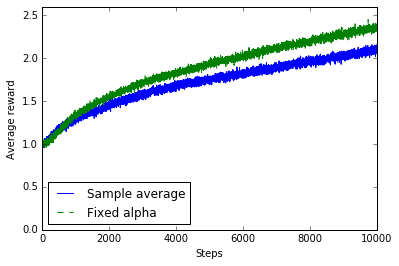

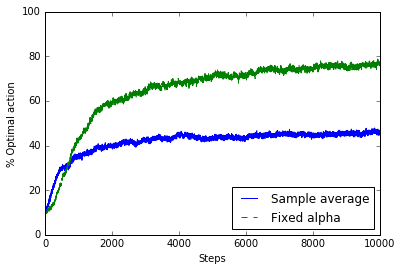

In [4]:
avgr_sample_avg = stats[0].get_avg_rewards()
avgr_fixed = stats[1].get_avg_rewards()
opta_sample_avg = stats[0].get_avg_optimacy()
opta_fixed = stats[1].get_avg_optimacy()
steps = np.arange(0, N_STEPS)

fig = plt.figure()
plt.plot(steps, avgr_sample_avg, 'b-', label='Sample average')
plt.plot(steps, avgr_fixed, 'g--', label='Fixed alpha')
plt.xlabel('Steps')
plt.ylabel('Average reward')
xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()
plt.axis([xmin, xmax, min(ymin, 0.), ymax])
plt.legend(loc=3)
plt.show()

fig = plt.figure()
plt.plot(steps, opta_sample_avg*100, 'b-', label='Sample average')
plt.plot(steps, opta_fixed*100, 'g--', label='Fixed alpha')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()
plt.axis([xmin, xmax, min(ymin, 0.), ymax])
plt.legend(loc=4)
plt.show()